# Sentiment analysis of Bluesky posts

In [1]:
import pandas as pd
import numpy as np
import snscrape.modules.twitter as sntwitter
from datetime import datetime
from tqdm.notebook import tqdm_notebook
import seaborn as sns
import matplotlib.pyplot as plt

## Get Bluesky "skeets" and store them in a dataframe

In [4]:
from bluesky.search_bluesky import search_bluesky,search_bluesky_batch

# this shows how free days affect bluesky posts
df = search_bluesky_batch(query='Field Museum', since_date='2023-03-25', until_date='2024-09-11', nbatch=20)

# this shows how the Archaeopteryx reveal affected bluesky posts
# df = search_bluesky(query="'Field Museum'", since_date="2024-05-01", until_date="2024-05-12")

df.head()

Number of posts: 1
Number of posts: 8
Number of posts: 4
Number of posts: 16
Number of posts: 29
Number of posts: 34
Number of posts: 35
Number of posts: 44
Number of posts: 46
Number of posts: 41
Number of posts: 34
Number of posts: 28
Number of posts: 39
Number of posts: 32
Number of posts: 43
Number of posts: 47
Number of posts: 22
Number of posts: 36
Number of posts: 40
Number of posts: 58


,User,Content,Likes,Reposts,date
0,seashore.bsky.social,Beach day yesterday in Chicago but 40-ish toda...,1,0,2023-04-16 18:05:00
0,surrealistship.bsky.social,"One of my favorite tourist days I've ever had,...",3,0,2023-05-16 19:18:00
1,annierar.bsky.social,"For some internet nostalgia, the Field Museum ...",0,0,2023-05-16 00:17:00
2,restingdinoface.bsky.social,"All sauropods are impressive, but I love that ...",5,1,2023-05-15 13:07:00
3,dancredentials.bsky.social,Field museum should get them,0,0,2023-05-14 00:10:00


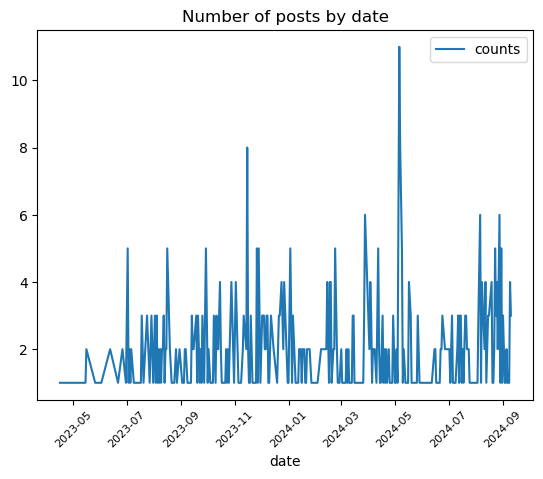

In [46]:
# Summarize number of rows by date
summary_by_date = df.groupby(df['date'].dt.date).size().reset_index(name='counts')
# print(summary_by_date)

summary_by_date.plot(x='date', y='counts', kind='line', title='Number of posts by date')
plt.xticks(rotation=45, fontsize=8)
plt.savefig('figs/timeline.png', dpi=300)

In [6]:
print("There are {} observations and {} features in this dataset. \n".format(df.shape[0],df.shape[1]))


There are 637 observations and 5 features in this dataset. 



## make a wordcloud

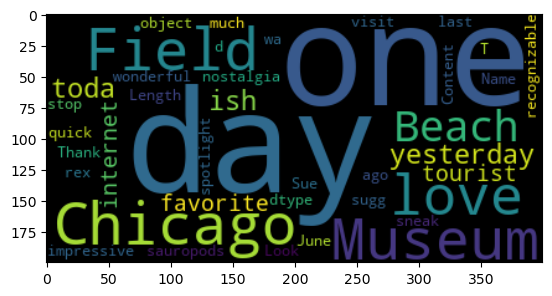

In [44]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

text = str(df.Content)

# text = text.replace('Field Museum', '')
# text = re.sub('[Nn]atural|[Mm]useum|[Hh]istory', '', text)
# text = re.sub('[Nn]atural', '', text)
# text = re.sub('[Nn]atural', '', text)

wc = WordCloud().generate(text)

plt.imshow(wc, interpolation='bilinear')

plt.savefig('figs/wordcloud.png', dpi=300)


## sentiment analysis



In [10]:
# sentiment analysis functions

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from textblob import TextBlob
import re

def get_post_sentiment(post):
    # create TextBlob object of passed bluesky post text
    analysis = TextBlob(post)
    # set sentiment
    if analysis.sentiment.polarity > 0:
        return 'positive'
    elif analysis.sentiment.polarity == 0:
        return 'neutral'
    else:
        return 'negative'

def get_post_sentiment_value(post):
    # create TextBlob object of passed bluesky post text
    analysis = TextBlob(post)
    # set sentiment
    return analysis.sentiment.polarity

def get_post_sentiment_vad(post):
    # create TextBlob object of passed bluesky post text
    analyzer = SentimentIntensityAnalyzer()
    vs = analyzer.polarity_scores(post)
    # set sentiment
    if vs['compound'] > 0:
        return 'positive'
    elif vs['compound'] == 0:
        return 'neutral'
    else:
        return 'negative'

def get_post_sentiment_vad_value(post):
    # create TextBlob object of passed bluesky post text
    analyzer = SentimentIntensityAnalyzer()
    vs = analyzer.polarity_scores(post)
    # set sentiment
    return vs['compound']


In [41]:
df['Sentiment'] = df['Content'].apply(get_post_sentiment_vad)
df['Sentiment_value'] = df['Content'].apply(get_post_sentiment_vad_value)
df.head()

# save output
df.to_csv('data/processed/FieldMuseum_2023-03-25_2024-09-11.csv', index=False)

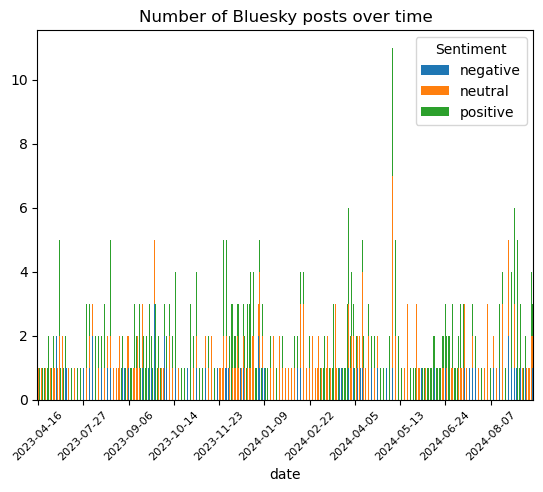

In [48]:
# now plot as a function of time and sentiment:

import seaborn as sns
import pandas as pd

# Summarize number of rows by date and sentiment
summary_by_date = df.groupby([df['date'].dt.date, 'Sentiment']).size().reset_index(name='counts')

# are there spikes on museum free days?
# print(summary_by_date.sort_values(by='counts', ascending=False))

# Line plot
# sns.lineplot(data=summary_by_date, x='date', y='counts', hue='Sentiment')
# plt.xticks(rotation=45, fontsize=8)

# Bar plot
summary_by_date.pivot(index='date', columns='Sentiment', values='counts').plot(kind='bar', stacked=True)
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(nbins=12))

plt.xticks(rotation=45, fontsize=8)

plt.title('Number of Bluesky posts over time')

# Add horizontal lines every Wednesday
for date in pd.date_range(start=summary_by_date['date'].min(), end=summary_by_date['date'].max(), freq='W-WED'):
    plt.axvline(date, color='gray', linestyle='--', linewidth=0.5)

# plt.show()

# save figure
plt.savefig('figs/timeline_sentiment.png', dpi=300)


In [13]:
# summary_by_date.sort_values('counts', ascending=False)

df.groupby(df['date'].dt.date).size().sort_values(ascending=False)


date
2024-05-06    11
2023-11-15     8
2024-05-07     8
2024-08-06     6
2024-03-28     6
              ..
2024-01-12     1
2024-01-16     1
2024-01-20     1
2024-01-21     1
2024-01-27     1
Length: 329, dtype: int64

In [14]:
# Pivot the summary_by_month DataFrame
# Summarize counts by month
df['month'] = df['date'].dt.to_period('M')
summary_by_month = df.groupby([df['month'], 'Sentiment']).size().reset_index(name='counts')
summary_by_month_wide = summary_by_month.pivot(index='month', columns='Sentiment', values='counts').fillna(0)

print(summary_by_month_wide)


Sentiment  negative  neutral  positive
month                                 
2023-04         0.0      2.0       1.0
2023-05         0.0      2.0       5.0
2023-06         2.0      3.0       2.0
2023-07         3.0     12.0      18.0
2023-08         9.0     14.0      19.0
2023-09         8.0     13.0      22.0
2023-10         9.0     14.0      26.0
2023-11         7.0     26.0      16.0
2023-12         2.0     17.0      24.0
2024-01         7.0     15.0      16.0
2024-02         3.0     20.0      17.0
2024-03         3.0     13.0      19.0
2024-04         8.0     20.0      17.0
2024-05         2.0     25.0      26.0
2024-06         3.0      4.0      20.0
2024-07         5.0     15.0      20.0
2024-08        10.0     27.0      29.0
2024-09         3.0      7.0       7.0


In [15]:
# Summarize number of posts by month and filter by negative sentiment
summary_by_month_negative = summary_by_month[summary_by_month['Sentiment'] == 'negative']

# Sort by decreasing counts
summary_by_month_negative_sorted = summary_by_month_negative.sort_values(by='counts', ascending=False)

summary_by_month_negative_sorted

,month,Sentiment,counts
46,2024-08,negative,10
10,2023-08,negative,9
16,2023-10,negative,9
13,2023-09,negative,8
34,2024-04,negative,8
19,2023-11,negative,7
25,2024-01,negative,7
43,2024-07,negative,5
7,2023-07,negative,3
28,2024-02,negative,3


In [16]:
# Sort by decreasing counts
summary_by_month_positive = summary_by_month[summary_by_month['Sentiment'] == 'positive']
summary_by_month_positive_sorted = summary_by_month_positive.sort_values(by='counts', ascending=False)

summary_by_month_positive_sorted

,month,Sentiment,counts
48,2024-08,positive,29
18,2023-10,positive,26
39,2024-05,positive,26
24,2023-12,positive,24
15,2023-09,positive,22
42,2024-06,positive,20
45,2024-07,positive,20
12,2023-08,positive,19
33,2024-03,positive,19
9,2023-07,positive,18


## Top-10 most "negative" posts

In [39]:
top_neg_posts = list(df[df['Sentiment'] == 'negative'].sort_values(by='Sentiment_value', ascending=True).head(10)['Content'])

# Wrap the text and add new lines
top_neg_posts = [textwrap.fill(post, width=100) for post in top_neg_posts]

print("\n\n".join(top_neg_posts))


Having an existential crisis going through the Death Exhibit at the Field Museum.

Interesse an der Kultur der Zapoteken, Mixteken oder allgemein für das vorkoloniale Mexiko? Morgen
hält Gary M. Feinman vom Field Museum in Chicago einen Vortrag in Kiel über die neuesten
Forschungsergebnisse, die sich aus der Analyse von Obsidianfunden ergeben haben 👇  🏺

Nearly 1,000 Birds Die After Striking Chicago Building At least 961 birds died in one night in
Chicago after crashing into the windows of the McCormick Place Lakeside Center during the height of
the fall migration.  Gifted article  www.nytimes.com/2023/10/08/u...

The first dinosaur fossils were identified in 1824, which means that: George Washington (d 1799),
Napoleon Bonaparte (d 1821), Jane Austen (d 1817), Daniel Boone (d 1820), all died without knowing
that dinosaurs existed. 😢🦖

Just a woman and her juvenile Alamosaurus.  Titanosaurians have weird ass feet. I took reference
photos of Maximo's feet while at the Field Museum and ye

NB: many of these aren't really negative. I might want to think about training my own word2vec kinda model for predicting sentiments.

## Top-10 most positive posts

In [35]:
import textwrap

# Get the top-10 most positive posts
top_pos_posts = list(df[df['Sentiment'] == 'positive'].sort_values(by='Sentiment_value', ascending=True).head(10)['Content'])

# Wrap the text and add new lines
top_pos_posts = [textwrap.fill(post, width=100) for post in top_pos_posts]

print("\n\n".join(top_pos_posts))


Hit the Field Museum, Schedd Aquarium, and Museum of Science and Industry today. They are listed
from best to worst with the last one far below the other two

I also recently saw Maximo the titanosaur at the Field Museum and it was so cool I cried a little.

I want my body tossed into a bin of flesh-eating beetles at the Field Museum, but they don't offer
that service, even though I've had a membership for decades.

I want my body put in a bin of flesh-eating beetles at the Field Museum, but they say they won't do
that even though I've been a member for decades. 🪲🪲🪲

Wish Sue from Chicago Field Museum was on bsky :-(

going to the field museum anyone want any dinosaur bones

He died doing what he loved.

So, I want to go to KORD to The Field Museum. To see the lions and the elephants. A simple weekend
trip. Museum, dinner, home.

Was reminded last night of the time when I was in NY for work and Stacey texted saying she was at an
event at the Field Museum and did I want to guess what sh

In [21]:
df['date2'] = df['date'].dt.date

df[df['date2'] == '2024-05-06']

# df.loc[47]['Content']

df.loc[47]

# text = df.loc[47]['Content']
# print(text)

# tb = TextBlob(text)
# tb.sentiment_assessments
# dir(tb)


User                                          boombutton.bsky.social
Content            The Field Museum has a small pod of narwhals i...
Likes                                                              2
Reposts                                                            0
date                                             2024-08-20 14:59:00
Sentiment                                                   positive
Sentiment_value                                               0.2714
month                                                        2024-08
date2                                                     2024-08-20
Name: 47, dtype: object